# RBF Interpolation: 2D Example
This notebook assumes you've looked through the intro and 1D example and have a basic understanding of what RBF interpolation attempts to do. In this notebook I'll be running through a couple of methods I attempted to use in trying to interpolate a field of topographic data. I chose topographic data becuase I have some experience dealing with it through my surface metrology research.

Starting with imports:

In [141]:
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import lsmr

Just like in the 1D example, we need to define functions for our bases. However in the 2D case, we need one function that can be evaluated over a 2D field, and another that can return the basis function value given a radial distance.

In [142]:
def gaussian2d(x,y, x0, y0, sigma):
    return np.exp(-((x-x0)**2/(2*sigma**2) + (y-y0)**2/(2*sigma**2)))

def gaussianR(r, sigma):
    return np.exp(-.5*(r/sigma)**2)

Now onto the first question of RBP interpolation: how to place the basis functions? Following the method from the 1D example of evenly spacing bases about the field gets slightly more complicated, as we have to evenly space them 2-dimensionally, and there is no garuntee that the x-axis is the same size as the y-axis. I approached this problem by first considering highly divisible numbers for the total number of bases. Then, by finding the closest two factors of these numbers, we can space the bases along each axis evenly. For finding proper factors, we can make a pretty simple function to find all factors, then select the middle-two values.

In [143]:
def get_factors(x):
    # get all factors of natural number x
    if x%1 != 0 or x<0:
        raise ValueError('Warning, not a natural number')

    factors = [1]
    if x%2==0:
        factors.append(2)
        for i in range(3,int(x/2 + 1)):
            if x%i == 0:
                factors.append(i)
    else:
        for i in range(3, int(x/2)):
            if x%i == 0:
                factors.append(i)
    if(x>2): factors.append(x)
    return np.array(factors)

hi_div = [1, 2, 4, 6, 12, 24, 36, 48, 60, 120, 180, 240] # first several highly divisible numbers
num_bases = hi_div[4] # = 12, first number thats good to work with
factors = get_factors(num_bases)
ind = np.where(factors>=sqrt(num_bases))[0][0] # finds index of first of closest 2 factors

Now we need a field to interpolate. We're going to be using topographic data from the High Peaks Region of the Adirondack Mountains in Upstate New York.

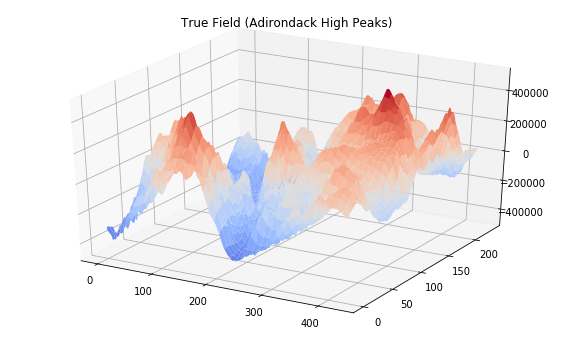

In [144]:
# load data set
# note the scale is kind of weird, I'm not sure what scale and units it uses
true_field = np.loadtxt('topo.txt')
x = range(len(true_field[0]))
y = range(len(true_field[:, 0]))
xv, yv = np.meshgrid(x, y)
# Plot True field
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv,yv,true_field, cmap='coolwarm')
plt.title('True Field (Adirondack High Peaks)');

This is a much more complex data set than the simple sine curve we looked at in the 1D example. But now that we have the field size we can see what our basis functions will look like.

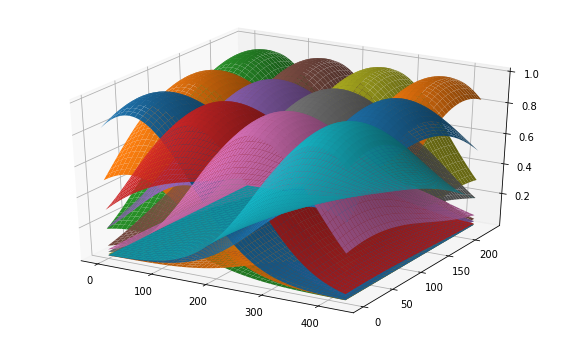

In [145]:
# Check which axis is larger and space more bases along that axis
if(len(x)>len(y)):
    num_x = factors[ind]
    num_y = factors[ind - 1]
    sigma = (max(x) - min(x)) / num_x # evenly spaced across the axis
else:
    num_x = factors[ind - 1]
    num_y = factors[ind]
    sigma = (max(y) - min(y)) / num_y # evenly space across the axis

# list of indices of bases in list of (xind, yind)
base_ind = []
xoffset = .5*len(x)/num_x
yoffset = .5*len(y)/num_y # offset to center the points
for i in range(1,num_x + 1):
    for k in range(1,num_y+1):
        base_ind.append((int(i*len(x)/num_x-xoffset),int(k*len(y)/num_y-yoffset)))

basis_field = np.zeros((len(y),len(x)))
basis_vis = plt.figure(figsize=(10,6))
ax = basis_vis.gca(projection='3d')
for point in base_ind:
    ibasis = gaussian2d(xv,yv,point[0],point[1],sigma)
    ax.plot_surface(xv,yv,ibasis)
    basis_field = basis_field + ibasis


So far so good. Now we select a few data points to interpolate. Since we're dealing with a larger data set here, instead of choosing random data points, I'm going to select some semi-evenly spaced points based on what I know about the field size.

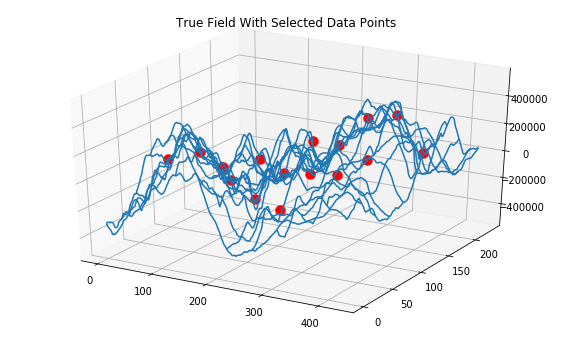

In [146]:
# selecting 16 points
xind = np.array([60, 160, 260, 360])
yind = np.array([50, 100, 150, 200])
xind = xind.repeat(4)
yind = np.tile(yind,4) # repeated and tiled to get 4x4 grid

zvals = true_field[yind,xind]
num_data = len(zvals)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xv,yv,true_field, cmap='Blues',rcount=10,ccount=10)
ax.scatter(xind,yind,zvals, c='r', linewidth=6,depthshade=False)
plt.title('True Field With Selected Data Points');

Now we can create the PHI matrix and perform least-squares regression to arrive at the appropriate basis weights. We do this in the same way as the 1D example, except we have to evaluate the basis functions radially to construct the PHI nmatrix

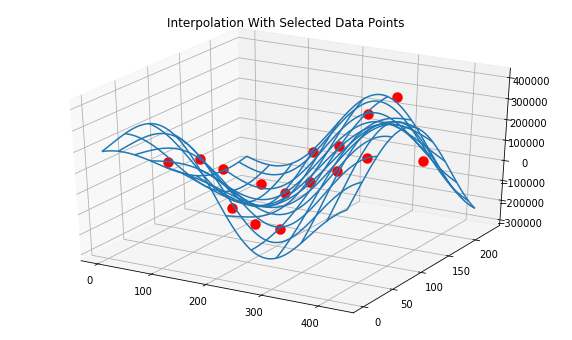

In [147]:
PHI=np.zeros((num_data, num_bases))
for i in range(num_data):
    for j in range(num_bases):
        # Radial evaluation of each basis function
        PHI[i,j] = gaussianR(r=np.sqrt((base_ind[j][0]-xind[i])**2 + (base_ind[j][1]-yind[i])**2), sigma=sigma)

w = lsmr(PHI,zvals)[0] # regularized least squares to prevent overfitting

# construction of the interpolation field
basis_interp = np.zeros((len(y),len(x)))
for i in range(len(w)):
    ibasis = w[i]*gaussian2d(xv,yv,base_ind[i][0],base_ind[i][1],sigma)
    basis_interp = basis_interp + ibasis
    
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xv,yv,basis_interp, cmap='Blues',rcount=10,ccount=10)
ax.scatter(xind,yind,zvals, c='r', linewidth=6,depthshade=False)
plt.title('Interpolation With Selected Data Points');

This interpolation is not bad, even if it does only give a rough (actually in this case smooth!) estimate of the true field. The idea for this procedure would be to continuosly pass more and more data points to the interpolation, ideally getting closer and close to the true field each time.

Like the 1D case, let's generalize the procedure to work for any 2D field and data points.

In [148]:
def rbf2D(field_size, num_bases, xind, yind, zvals):
    '''
    RBF interpolation of a 2D field
    :param field_size: tuple / 2-element list containing the x and y sizes of the field
    :param num_bases: number of bases to use in the interpolation, MUST BE NON-PRIME, PREFERABLE HIGHLY DIVISIBLE
    :param xind: x-indicies of data points to be interpolated
    :param yind: y-indicies of data points to be interpolated
    :param zvals: z-values of data points to be interpolated
    
    :return: RBF interpolation of the field
    '''
    x = range(field_size[0])
    y = range(field_size[1])
    xv, yv = np.meshgrid(x, y)
    # define constant number of bases, uniform sigma, choosing highly divisible numbers
    factors = get_factors(num_bases)
    ind = np.where(factors>=sqrt(num_bases))[0][0] # finds closest 2 factors

    # selecting which axis to space more bases on
    if(len(x)>len(y)):
        num_x = factors[ind]
        num_y = factors[ind - 1]
        sigma = (max(x) - min(x)) / num_x
    else:
        num_x = factors[ind - 1]
        num_y = factors[ind]
        sigma = (max(y) - min(y)) / num_y

    # list of basis indices, in (xind, yind) form
    base_ind = []
    xoffset = .5*len(x)/num_x
    yoffset = .5*len(y)/num_y # need to center the points
    for i in range(1,num_x + 1):
        for k in range(1,num_y+1):
            base_ind.append((int(i*len(x)/num_x-xoffset),int(k*len(y)/num_y-yoffset)))

    # Creation of the matrix Phi in the system Phi * w = z where
    # Phi[i,j] = phi_j(p_i)     p_i = location of height z_i    w = weights
    num_data = len(xind)
    PHI=np.zeros((num_data, num_bases))
    for i in range(num_data):
        for j in range(num_bases):
            # Radial evaluation of each basis function
            PHI[i,j] = gaussianR(r=np.sqrt((base_ind[j][0]-xind[i])**2 + (base_ind[j][1]-yind[i])**2), sigma=sigma)
            
    # Least squares approximation of weights on basis functions
    w = lsmr(PHI, zvals)[0]

    # basis approximation array, multiply weights by each basis function and add into one array
    basis_interp = np.zeros((len(y),len(x)))
    for i in range(len(w)):
        ibasis = w[i]*gaussian2d(xv,yv,base_ind[i][0],base_ind[i][1],sigma)
        basis_interp = basis_interp + ibasis

    return basis_interp

Let's check the function to make sure we get the same results as above.

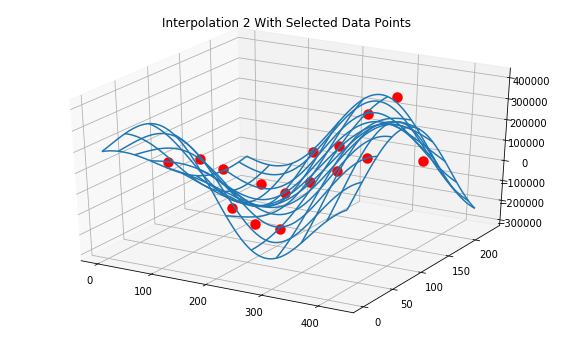

In [149]:
basis_interp2 = rbf2D([len(x),len(y)], 12, xind, yind, zvals)
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xv,yv,basis_interp2, cmap='Blues',rcount=10,ccount=10)
ax.scatter(xind,yind,zvals, c='r', linewidth=6,depthshade=False)
plt.title('Interpolation 2 With Selected Data Points');

Looks good!

Just a few more things to note: First off the interpolation will generally not be as good if random points are chosen, as there will be unequal concentration of data points throughout the field. This may leave some "dead-zones" of the field where no data is really picked up.

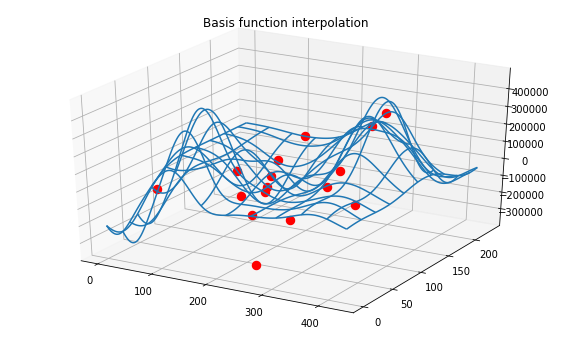

In [150]:
num_rand_points = 16
xind = np.random.randint(0, x[-1], num_rand_points)
yind = np.random.randint(0, y[-1], num_rand_points)
zvals = true_field[yind,xind]

RBF_rand_interp = rbf2D([len(x),len(y)],12, xind, yind, zvals)


# Plot the interpolation vs the scatter
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.gca(projection='3d')
ax1.plot_wireframe(xv,yv,RBF_interp,cmap='Blues',rcount=10,ccount=10)
ax1.scatter(xind,yind,zvals,c='r', linewidth=5, depthshade=False)
plt.title("Basis function interpolation");

You can see that while some areas are mapped better, others are almost completely neglected. With some intelligent data placement, we could ideally chose points within these "dead zones" to get a better interpolation of the field, or try to precicely map specific areas of interest. However, such algorithms are outside the scope of this demonstration.

Second, something to notice is that by utilizing regularized least squares, we avoid the problem of overfitting. Observe this example, using 5 data points and 128 bases:

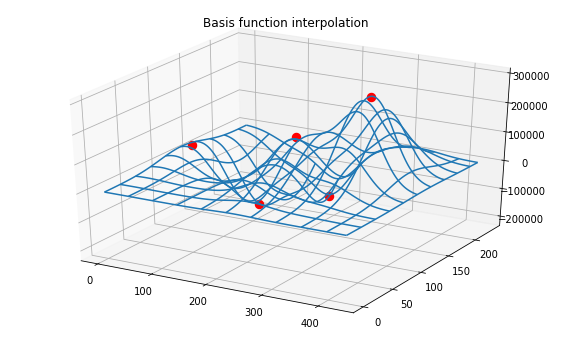

In [151]:
num_rand_points2 = 5
xind = np.random.randint(0, x[-1], num_rand_points2)
yind = np.random.randint(0, y[-1], num_rand_points2)
zvals = true_field[yind,xind]

RBF_rand_interp2 = rbf2D([len(x),len(y)],128, xind, yind, zvals)


# Plot the interpolation vs the scatter
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.gca(projection='3d')
ax1.plot_wireframe(xv,yv,RBF_rand_interp2,cmap='Blues',rcount=10,ccount=10)
ax1.scatter(xind,yind,zvals,c='r', linewidth=5, depthshade=False)
plt.title("Basis function interpolation");

That concludes this demonstration. Plans to continue development on this project in the future include integration of iterative data point selection and applications to more different kinds of "threat fields."